In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime as dt
import math
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Table of contents
1. [Importing data](#importing)
2. [Exploring data](#exploring)
3. [Visualising the data](#visual)
4. [Data quality problems](#quality)
    1. [Missing data](#missing)
    2. [Outliers](#outliers)
    3. [Correlated features](#corr)
5. [Feature engineering](#feature)
6. [Aggregating the data](#agg)


### Summary of data exploration (and basic pre-processing):

#### Importing data  
* Made column names shorter and understandable (English), converted dates to datetime object, ids to category type
* Made a unique market+fridge group identifier  
#### Exploring data  
* Looked at scale of data (30096, 120384, 36875, 368749 observations and 5-11 columns respectively in the datasets) - longer than wide, few features  
* 22 markets, 27 groups of fridges, and 270 fridges. There is anything from 1 to 21 fridges in a group.   
* The data have very different scales: percentage/temperatures. Normalisation may be necessary  
* The time period that each of the markets have recorded date for is different for each market 
#### Visualising data  
* Used boxplots to visualise distributions: approx normal, vast majority of data within narrow bounds  
* Made line plot of a single fridge temp over time, and all fridges temp over time, with door seal change day marked  
* Made line plot of a single market chiller power over time
#### Missing data 
* Almost half of the market observations have missing outside building temperatures, and humidity recordings. 40% of the market observations have missing energy usage values. Almost half of the fridge group observations have missing chiller power measurements. 22% of the fridge group observations are missing an associated fridge group.  
* Missing values tend to occur more in some markets than others, and the majority of the time, the entire variable is missing for that market, suggesting this is a case of a measurement not having been recorded   
* Only 16 supermarkets appear in all 4 of the datasets, compared to the 22 supermarkets in the market dataset. Why are they missing? The missing markets [94244, 80551, 95562, 92397, 93774, 94954] also have a lot of missing values.
#### Handling missing data
* Dropping missing values is a problem when the reason the values are missing is related to the problem of interest.  
* When the data is missing, it is not just a few values: it is an entire variable measurement. Therefore I do not think that imputing the data would be useful, because this would simply involve deriving likely values based on the existing variables/supermarkets, and thus information is simply being duplicated rather than being added to the dataset.  
* I therefore believe that it is safe to simply drop the markets with large amounts of missing data, as very little information is being lost in doing so, and I believe that it is unlikely that the reason the data is missing would be associated with the door seal results, due to the homogenous nature of most markets. Without additional knowledge about the markets each marketId is associated with, we cannot include that these markets were exceptional instances, whose inclusions in the analysis would be important.  
* The market 93593 is missing around 1% of its values, all on exactly the same date (2021-12-20), 6 days after door seal changed, (so likely not associated). There is a steep change in temperature around the date of the missing data (and no clear seasonal factor) therefore imputation may be inappropriate.
* There are only a very few cases of small amounts of missing data values, thus these can be manually inspected to ascertain the best approach
#### Outliers
* Almost all of the values do not seem to be outliers: all of the values make practical sense (as the temperatures) or do not exceed expected bounds (such as the measurements given in percent).
* Although the boxplot marks many values as outliers on some of the figures, such as "outlet air temp" and "inlet air temp", this is moreso a result of the fact that the vast majority of the observations exist within an extremely small range of values. Unique situations that caused, for example, a high heat pump utilisation to be required, may in fact of interest to the analysis, in determining what caused this unique event.
* For now the only data values that should be removed are outliers which reflect incorrect data, rather than unique/extreme cases
* 90% of the observations have an "expected temp" of 6 degrees, with 10% having an expected temp of 1 degree. 10% is a significant enough proportion that I would assume that this figure is not a mistake, but rather reflecting that there are different types of fridges in the dataset (with different set/expected temperatures).
* There is one obviously problematic outlier, an evaporation temperature measurement that is -40. I chose to fix this by imputing it with the preceeding value. This is appropriate due to the time stamp nature of the data, and a time plot looks consistent even after the change.
* While the majority of the supermarkets have humidity values around 25-50, there is one supermarket with humidity values that are almost always around 100. This is so unusual that I assume this is due to faulty measurements.
#### Correlated features
* Outside building temperature and outside pump temperature are very highly correlated, thus it is likely that only one of these features would be necessary in a final model. None of the other features initially appear to be particuarly highly correlated. 
* As there are only a very small number of features to begin with, I believe a PCA reduction on this dataset to be unnecessary. Correlated features would likely be removed from a model during a variable selection process anyway.
* The actual and inlet air temperatures appear correlated, with some odd clusters, which seem potentially related to certain markets/fridge groups. As a result, I would not consider dropping any features at this stage.
#### Feature engineering
* Made a unique market+fridge group identifier, allowing the different datasets to more easily be merged
* I create a feature showing the difference between the actual and expected fridge temperatures, as this may be useful in the analysis.
* We can also extract only the current day from the date column, in order to be able to compare it to the seal change date later.
* Each market had all of its seals changed on one day. Therefore this information can be added to the other datasets.
* I also created a feature which describes whether or not an observation was recorded before or after the door seal was changed.
#### Aggregating the data
* The energy dataset uses 15 minute intervals, whereas the other datasets use 1 hour intervals, hence the energy dataset should have its data aggregated to 1 hour. I used mean and sum for this, as appropriate for each unit.
* Using the ids shared between the datasets (market id/fridge group id) I merged all of the datasets together with the lowest level "fridge" dataset. As the data does not use a relational form, there is thus a lot of repetition of data.
* The final "extended fridge" dataset contains 368,749 observations across 27 variables

## Importing data <a name="importing"></a>
Made column names shorter and more understandable, converted date columns to datetime object.  
Later, convert id columns to category type.

In [3]:
markets = pd.read_csv('/store/projects/ddm-ws2022/wurm/Marktdaten.csv', parse_dates=["date"], header=0,
                    names=["marketId", "date", "outsideTemp", "outsideTempHeatPump", "temp", "humidity"])
energy = pd.read_csv('/store/projects/ddm-ws2022/wurm/Energiedaten.csv', parse_dates=["date"], header=0,
                    names=["marketId", "date", "energyUsageCooling", "energyUsageOtherCooling", "energyUsageTotal"])
heatpumps = pd.read_csv('/store/projects/ddm-ws2022/wurm/VerbundDaten.csv', parse_dates=["date"], header=0,
                    names=["marketId", "hpId", "date", "measuredTempEvap", "setTempEvap", "workload", "chillingPower"])
fridges = pd.read_csv('/store/projects/ddm-ws2022/wurm/KSTDaten.csv', parse_dates=["date", "sealChange"], header=0,
                    names=["marketId", "fridgeId", "hpId", "date", "measuredTempFridge", "setTempFridge", "tempAirOut", "tempAirIn", "defrostTime(%)", "offTime(%)", "sealChange"])

## Exploring data<a name="exploring"></a>

In [5]:
markets.head()

,marketId,date,outsideTemp,outsideTempHeatPump,temp,humidity
0,80551,2021-11-15 00:00:00+00:00,NaN,10.050,19.000,NaN
1,80551,2021-11-15 01:00:00+00:00,NaN,9.750,19.125,NaN
2,80551,2021-11-15 02:00:00+00:00,NaN,10.050,19.000,NaN
3,80551,2021-11-15 03:00:00+00:00,NaN,9.750,19.000,NaN
4,80551,2021-11-15 04:00:00+00:00,NaN,9.650,19.250,NaN


In [6]:
markets["marketId"] = markets["marketId"].astype("category")

In [7]:
markets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   marketId             30096 non-null  category           
 1   date                 30096 non-null  datetime64[ns, UTC]
 2   outsideTemp          16371 non-null  float64            
 3   outsideTempHeatPump  20433 non-null  float64            
 4   temp                 27343 non-null  float64            
 5   humidity             16276 non-null  float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(4)
memory usage: 1.2 MB


In [8]:
energy.head()

,marketId,date,energyUsageCooling,energyUsageOtherCooling,energyUsageTotal
0,80551,2021-11-15 00:00:00+00:00,0.000,0.000,0.000
1,80551,2021-11-15 00:15:00+00:00,0.000,0.000,0.000
2,80551,2021-11-15 00:30:00+00:00,0.000,0.000,0.000
3,80551,2021-11-15 00:45:00+00:00,0.000,0.000,0.000
4,80551,2021-11-15 01:00:00+00:00,0.000,0.000,0.000


In [9]:
energy["marketId"] = energy["marketId"].astype("category")

In [10]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120384 entries, 0 to 120383
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   marketId                 120384 non-null  category           
 1   date                     120384 non-null  datetime64[ns, UTC]
 2   energyUsageCooling       114715 non-null  float64            
 3   energyUsageOtherCooling  109243 non-null  float64            
 4   energyUsageTotal         71061 non-null   float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(3)
memory usage: 3.8 MB


In [11]:
heatpumps["hpId"] = heatpumps["hpId"].astype(float)

In [12]:
heatpumps["uniqueHpId"] = heatpumps["marketId"].astype(str) + "." + heatpumps["hpId"].astype(str)

In [13]:
heatpumps["hpId"] = heatpumps["hpId"].astype("category")
heatpumps["uniqueHpId"] = heatpumps["uniqueHpId"].astype("category")
heatpumps["marketId"] = heatpumps["marketId"].astype("category")

In [14]:
heatpumps.head()

,marketId,hpId,date,measuredTempEvap,setTempEvap,workload,chillingPower,uniqueHpId
0,81679,1.000,2021-11-10 00:00:00+00:00,0.250,0.400,29.000,13.875,81679.1.0
1,81679,1.000,2021-11-10 01:00:00+00:00,0.050,0.000,33.000,15.125,81679.1.0
2,81679,1.000,2021-11-10 02:00:00+00:00,0.550,0.650,25.000,11.875,81679.1.0
3,81679,1.000,2021-11-10 03:00:00+00:00,-0.050,0.100,30.000,14.250,81679.1.0
4,81679,1.000,2021-11-10 04:00:00+00:00,-0.500,-0.100,27.000,12.750,81679.1.0


In [15]:
fridges["uniqueHpId"] = fridges["marketId"].astype(str) + "." + fridges["hpId"].astype(str)

In [16]:
fridges["marketId"] = fridges["marketId"].astype("category")
fridges["fridgeId"] = fridges["fridgeId"].astype("category")
fridges["hpId"] = fridges["hpId"].astype("category")
fridges["uniqueHpId"] = fridges["uniqueHpId"].astype("category")

In [17]:
fridges.head()

,marketId,fridgeId,hpId,date,measuredTempFridge,setTempFridge,tempAirOut,tempAirIn,defrostTime(%),offTime(%),sealChange,uniqueHpId
0,85679,1171,1.000,2021-11-15 00:00:00+00:00,6.500,6.000,6.500,6.500,50.000,0.000,2021-12-13,85679.1.0
1,85679,1171,1.000,2021-11-15 01:00:00+00:00,7.000,6.000,7.500,7.000,50.000,0.000,2021-12-13,85679.1.0
2,85679,1171,1.000,2021-11-15 02:00:00+00:00,5.750,6.000,6.000,5.500,0.000,0.000,2021-12-13,85679.1.0
3,85679,1171,1.000,2021-11-15 03:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,2021-12-13,85679.1.0
4,85679,1171,1.000,2021-11-15 04:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,2021-12-13,85679.1.0


In [18]:
fridges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368749 entries, 0 to 368748
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   marketId            368749 non-null  category           
 1   fridgeId            368749 non-null  category           
 2   hpId                285473 non-null  category           
 3   date                368749 non-null  datetime64[ns, UTC]
 4   measuredTempFridge  368720 non-null  float64            
 5   setTempFridge       368720 non-null  float64            
 6   tempAirOut          368720 non-null  float64            
 7   tempAirIn           368720 non-null  float64            
 8   defrostTime(%)      368748 non-null  float64            
 9   offTime(%)          368748 non-null  float64            
 10  sealChange          368749 non-null  datetime64[ns]     
 11  uniqueHpId          368749 non-null  category           
dtypes: category(4), 

In [4]:
fridges["setTempFridge"]\
.value_counts()

6.000     305812
1.000      34132
4.000      15048
2.000       5472
3.000       1368
5.000       1368
5.500       1368
10.000      1368
1.500       1368
7.000       1368
0.000         48
Name: setTempFridge, dtype: int64

#### Scale of the data   

In each of the datasets are 30096, 120384, 36875, 368749 observations, and 5-11 columns respectively.  
Therefore the data is much longer than it is wide, and there are relatively very few features.

There are 22 individual markets, 27 groups of fridges, and 270 unique fridges recorded.
There is anything from 1 to 21 fridges in a group.

In [19]:
fridges.groupby("uniqueHpId")["fridgeId"].nunique().sort_values()

uniqueHpId
94044.3.0     1
91777.3.0     1
89020.2.0     1
88706.2.0     1
81679.2.0     2
82994.2.0     2
83550.2.0     2
83923.2.0     2
85679.2.0     2
83202.2.0     3
83692.2.0     3
81679.1.0     9
83202.1.0     9
94044.2.0    10
91777.2.0    11
91728.2.0    11
88706.1.0    11
83692.1.0    11
83550.1.0    11
82994.1.0    11
89020.1.0    12
83923.1.0    12
92232.1.0    12
93774.nan    12
82601.2.0    12
94244.nan    12
94954.nan    12
95562.nan    12
85679.1.0    13
92397.nan    13
93593.2.0    13
94574.2.0    21
Name: fridgeId, dtype: int64

## Visualising the data<a name="visual"></a>

#### Distribution of the data  

The different variables of the data have extremely different scales: from a percentage based, to small temperature changes. Therefore the data would need to be normalised within a model.

In [20]:
markets.describe()

,outsideTemp,outsideTempHeatPump,temp,humidity
count,16371.000,20433.000,27343.000,16276.000
mean,4.820,5.725,18.542,46.708
std,4.209,3.839,2.889,16.198
min,-12.875,-11.600,8.000,11.000
25%,2.100,3.450,16.650,38.000
50%,5.000,5.750,18.550,44.000
75%,7.825,8.300,20.650,50.000
max,17.425,16.200,26.450,100.000


In [21]:
energy.describe()

,energyUsageCooling,energyUsageOtherCooling,energyUsageTotal
count,114715.000,109243.000,71061.000
mean,3.938,2.243,6.985
std,1.396,0.827,6.117
min,0.000,0.000,0.000
25%,3.225,1.800,0.300
50%,3.950,2.250,6.750
75%,4.750,2.750,9.950
max,11.125,5.297,32.475


In [22]:
heatpumps.describe()

,measuredTempEvap,setTempEvap,workload,chillingPower
count,36870.000,36870.000,36870.000,21822.000
mean,-4.530,-4.275,27.867,13.616
std,2.954,2.818,14.012,9.790
min,-44.400,-12.600,0.000,0.000
25%,-6.500,-6.000,18.000,5.375
50%,-5.350,-5.000,27.000,12.625
75%,-2.000,-2.000,36.000,19.750
max,1.750,1.400,87.000,49.125


In [23]:
fridges.describe()

,measuredTempFridge,setTempFridge,tempAirOut,tempAirIn,defrostTime(%),offTime(%)
count,368720.000,368720.000,368720.000,368720.000,368748.000,368748.000
mean,5.430,5.381,5.948,4.631,4.525,0.013
std,1.609,1.585,1.624,1.812,16.169,1.124
min,-1.000,0.000,0.000,-3.500,0.000,0.000
25%,5.750,6.000,6.000,4.500,0.000,0.000
50%,6.000,6.000,6.250,5.250,0.000,0.000
75%,6.000,6.000,6.500,5.500,0.000,0.000
max,12.500,10.000,14.750,13.250,100.000,100.000


<AxesSubplot:>

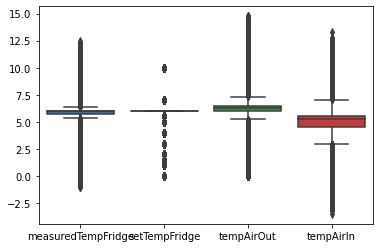

In [24]:
sns.boxplot(data=fridges[["measuredTempFridge", "setTempFridge", "tempAirOut", "tempAirIn"]])

The vast majority of the data stay within extremely narrow bounds, with a small amount of data at extremes to either side of it. The distribution of the data is approximately normal.

Text(0.5, 1.0, 'Fridge 1171')

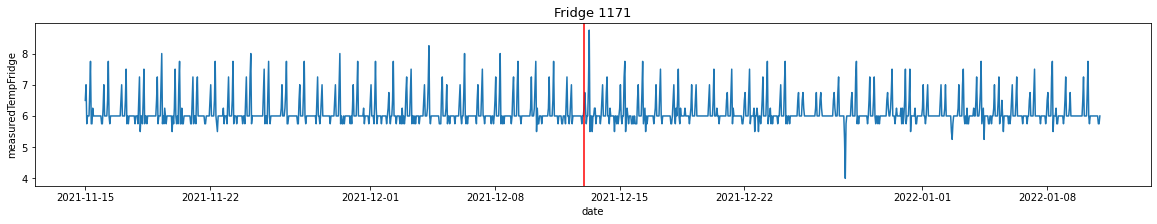

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(data = fridges[fridges["fridgeId"]==1171], x="date", y="measuredTempFridge", ax=ax)
ax.axvline(x=fridges.iloc[0, 10], color="red")
ax.set_title("Fridge 1171", fontsize=13)

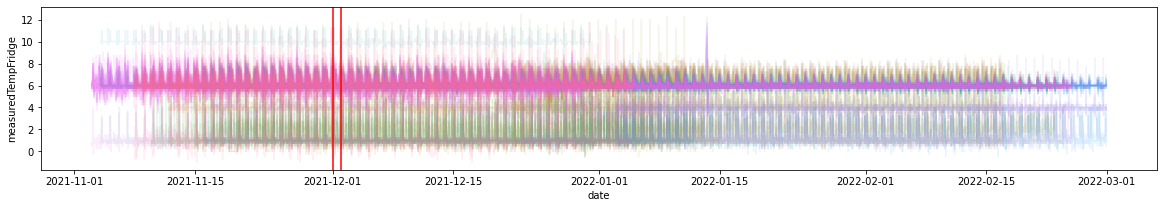

In [26]:
change_days = list(fridges["sealChange"].unique())
change_days.sort()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(data = fridges[["fridgeId", "date", "measuredTempFridge"]], x="date", y="measuredTempFridge", hue="fridgeId", alpha=0.1, ax=ax)
ax.get_legend().remove()
ax.axvline(x=change_days[0], color="red")
ax.axvline(x=change_days[1], color="red")

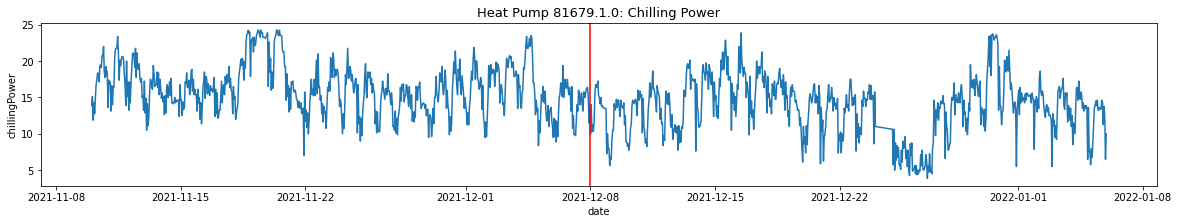

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(data = heatpumps[heatpumps["uniqueHpId"]=="81679.1.0"], x="date", y="chillingPower", ax=ax)
ax.set_title("Heat Pump 81679.1.0: Chilling Power", fontsize=13)
ax.axvline(x=list(fridges[fridges["uniqueHpId"]=="81679.1.0"]["sealChange"])[0], color="red")

The time period that each of the markets have recorded data for, is different across all of the markets.

In [28]:
markets.groupby("marketId")["date"].aggregate(["min", "max"])

,min,max
marketId,,
80551,2021-11-15 00:00:00+00:00,2022-01-10 23:00:00+00:00
81679,2021-11-10 00:00:00+00:00,2022-01-05 23:00:00+00:00
82601,2021-12-28 00:00:00+00:00,2022-02-22 23:00:00+00:00
82994,2021-11-15 00:00:00+00:00,2022-01-10 23:00:00+00:00
83202,2021-11-17 00:00:00+00:00,2022-01-12 23:00:00+00:00
83550,2021-11-19 00:00:00+00:00,2022-01-14 23:00:00+00:00
83692,2021-12-22 00:00:00+00:00,2022-02-16 23:00:00+00:00
83923,2021-11-12 00:00:00+00:00,2022-01-07 23:00:00+00:00
85679,2021-11-15 00:00:00+00:00,2022-01-10 23:00:00+00:00


## Data quality problems<a name="quality"></a>

### Identifying missing data<a name="missing"></a>

In [29]:
markets.isna().sum()/len(markets)*100

marketId               0.000
date                   0.000
outsideTemp           45.604
outsideTempHeatPump   32.107
temp                   9.147
humidity              45.920
dtype: float64

In [30]:
energy.isna().sum()/len(energy)*100

marketId                   0.000
date                       0.000
energyUsageCooling         4.709
energyUsageOtherCooling    9.255
energyUsageTotal          40.971
dtype: float64

In [31]:
heatpumps.isna().sum()/len(heatpumps)*100

marketId            0.000
hpId                0.000
date                0.000
measuredTempEvap    0.014
setTempEvap         0.014
workload            0.014
chillingPower      40.822
uniqueHpId          0.000
dtype: float64

In [32]:
fridges.isna().sum()/len(fridges)*100

marketId              0.000
fridgeId              0.000
hpId                 22.583
date                  0.000
measuredTempFridge    0.008
setTempFridge         0.008
tempAirOut            0.008
tempAirIn             0.008
defrostTime(%)        0.000
offTime(%)            0.000
sealChange            0.000
uniqueHpId            0.000
dtype: float64

Almost half of the market observations have missing outside building temperatures, and humidity recordings.  
40% of the market observations have missing energy usage values.  
Almost half of the fridge group observations have missing chiller power measurements.  
22% of the fridge group observations are missing an associated fridge group.  

Only 16 supermarkets appear in all 4 of the datasets, compared to the 22 supermarkets in the market dataset. 
Business knowledge would be required to understand why 6 markets are missing, and if those 6 markets are important to the analysis.

In [33]:
markets_in_market = set(markets["marketId"])
markets_in_fridge_group = set(heatpumps["marketId"])
markets_in_energy = set(energy["marketId"])
markets_in_fridge = set(fridges["marketId"])

In [34]:
len(set.intersection(markets_in_market, markets_in_fridge_group, markets_in_energy, markets_in_fridge))

16

Are the missing values associated with particular markets/fridge groups, or are they random?

In [35]:
markets.groupby("marketId", dropna=False).apply(lambda df: df.isna().sum()/len(df)*100)

,marketId,date,outsideTemp,outsideTempHeatPump,temp,humidity
marketId,,,,,,
80551,0.000,0.000,100.000,3.143,0.000,100.000
81679,0.000,0.000,100.000,0.000,100.000,100.000
82601,0.000,0.000,100.000,100.000,0.000,0.000
82994,0.000,0.000,100.000,100.000,0.000,0.000
83202,0.000,0.000,100.000,0.000,0.000,100.000
83550,0.000,0.000,0.000,0.000,0.000,0.000
83692,0.000,0.000,0.000,0.000,0.000,100.000
83923,0.000,0.000,0.000,0.000,0.000,0.000
85679,0.000,0.000,0.000,0.000,0.000,100.000


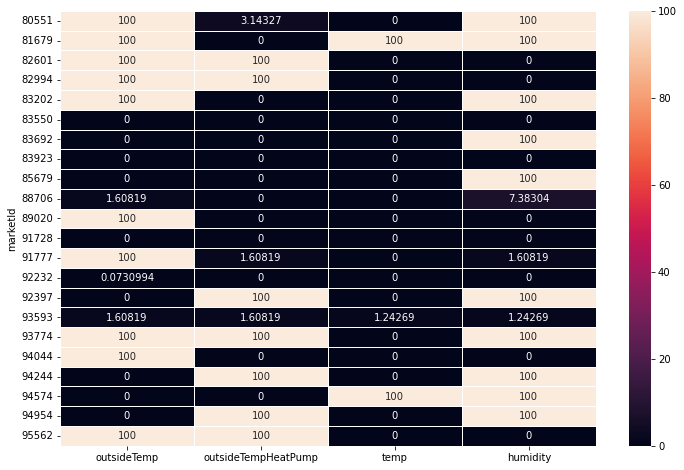

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax = sns.heatmap(markets.groupby("marketId", dropna=False).apply(lambda df: df.isna().sum()/len(df)*100).drop(["marketId", "date"], axis=1),
                xticklabels=True, yticklabels=True, ax=ax, linecolor="white", linewidths=1, annot=True, fmt="g")

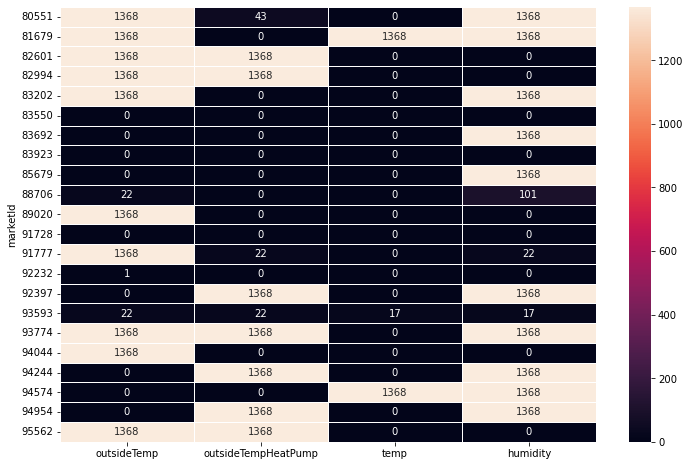

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax = sns.heatmap(markets.groupby("marketId", dropna=False).apply(lambda df: df.isna().sum()).drop(["marketId", "date"], axis=1),
                xticklabels=True, yticklabels=True, ax=ax, linecolor="white", linewidths=1, annot=True, fmt="g")

It seems like missing values occur more frequently in some markets than others, and the majority of the time, the entire variable is missing for a particular market.  
This would suggest that the data is missing simply because it hasn't been recorded for that supermarket. It therefore is likely impossible to get the original data.

In [38]:
list(set(markets_in_market - set.intersection(markets_in_market, markets_in_fridge_group, markets_in_energy, markets_in_fridge)))

[94244, 80551, 95562, 92397, 93774, 94954]

In [39]:
markets.groupby("marketId", dropna=False).apply(lambda df: df.isna().sum()/len(df)*100).loc[list(set(markets_in_market - set.intersection(markets_in_market, markets_in_fridge_group, markets_in_energy, markets_in_fridge)))]

,marketId,date,outsideTemp,outsideTempHeatPump,temp,humidity
marketId,,,,,,
94244,0.000,0.000,0.000,100.000,0.000,100.000
80551,0.000,0.000,100.000,3.143,0.000,100.000
95562,0.000,0.000,100.000,100.000,0.000,0.000
92397,0.000,0.000,0.000,100.000,0.000,100.000
93774,0.000,0.000,100.000,100.000,0.000,100.000
94954,0.000,0.000,0.000,100.000,0.000,100.000


The supermarkets that are missing between the total datasets also have a lot of missing values.

In [40]:
heatpumps.groupby("uniqueHpId", dropna=False).apply(lambda df: df.isna().sum()/len(df)*100)["chillingPower"]

uniqueHpId
81679.1.0     0.000
81679.2.0     0.000
82601.2.0   100.000
82994.1.0   100.000
82994.2.0   100.000
83202.1.0   100.000
83202.2.0   100.000
83550.1.0   100.000
83550.2.0   100.000
83692.1.0   100.000
83692.2.0   100.000
83923.1.0   100.000
83923.2.0   100.000
85679.1.0     0.000
85679.2.0     0.000
88706.1.0     0.000
88706.2.0     0.000
89020.1.0     0.000
89020.2.0     0.000
91728.2.0     0.000
91777.2.0     0.000
91777.3.0     0.000
92232.1.0     0.000
93593.2.0     0.370
94044.2.0     0.000
94044.3.0     0.000
94574.2.0     0.000
Name: chillingPower, dtype: float64

As with the markets, the missing values occur almost entirely within a few fridge groups, within which the measurements are completely missing. In this case it is more problematic, because the chiller power variable is one that could be relevant to the analysis.

What fridges are missing a group id, and why?

In [41]:
fridges[fridges["hpId"].isna()]["fridgeId"].unique()

[414286, 414287, 414288, 414289, 414294, ..., 471299, 471302, 471304, 471306, 471309]
Length: 61
Categories (270, int64): [1171, 1175, 1177, 1180, ..., 471302, 471304, 471306, 471309]

In [42]:
fridges[fridges["hpId"].isna()]["marketId"].unique()

[93774, 94954, 95562, 94244, 92397]
Categories (21, int64): [81679, 82601, 82994, 83202, ..., 94244, 94574, 94954, 95562]

In [43]:
list(set(markets_in_market - set.intersection(markets_in_market, markets_in_fridge_group, markets_in_energy, markets_in_fridge)))

[94244, 80551, 95562, 92397, 93774, 94954]

The fridges that are missing group ids are from the same supermarkets that are missing other data.

### Handling missing data

Dropping missing values is a problem when the reason the values are missing is related to the problem of interest.

When the data is missing, it is not just a few values: it is an entire variable measurement. Therefore I do not think that imputing the data would be useful, because this would simply involve deriving likely values based on the existing variables/supermarkets, and thus information is simply being duplicated rather than being added to the dataset.

Furthermore, the supermarkets that are missing between the datasets also have a lot of missing values - and these missing values occur across all of the datasets, i.e. it is the same supermarkets that lack data on fridge groups and on temperatures, etc.

I therefore believe that it is safe to simply drop the markets with missing data, as very little information is being lost in doing so, and I believe that it is unlikely that the reason the data is missing would be associated with the door seal results, due to the homogenous nature of most markets. Without additional knowledge about the markets each marketId is associated with, we cannot include that these markets were exceptional instances, whose inclusions in the analysis would be important.

One of the markets is missing a value for the date of the door seal change. Without this information this market simply cannot be used.

With the case of the fridge group missing chiller power values, the missing data is more problematic, but again I do not believe imputation is appropriate. In truth, the best course of action would be to "requery".

In a few cases, there are a very small number of data values missing. For example, the market 93593 is missing around 1% of its values, all on exactly the same date.

In [44]:
markets[markets["marketId"]==93593].isnull().sum()

marketId                0
date                    0
outsideTemp            22
outsideTempHeatPump    22
temp                   17
humidity               17
dtype: int64

<AxesSubplot:>

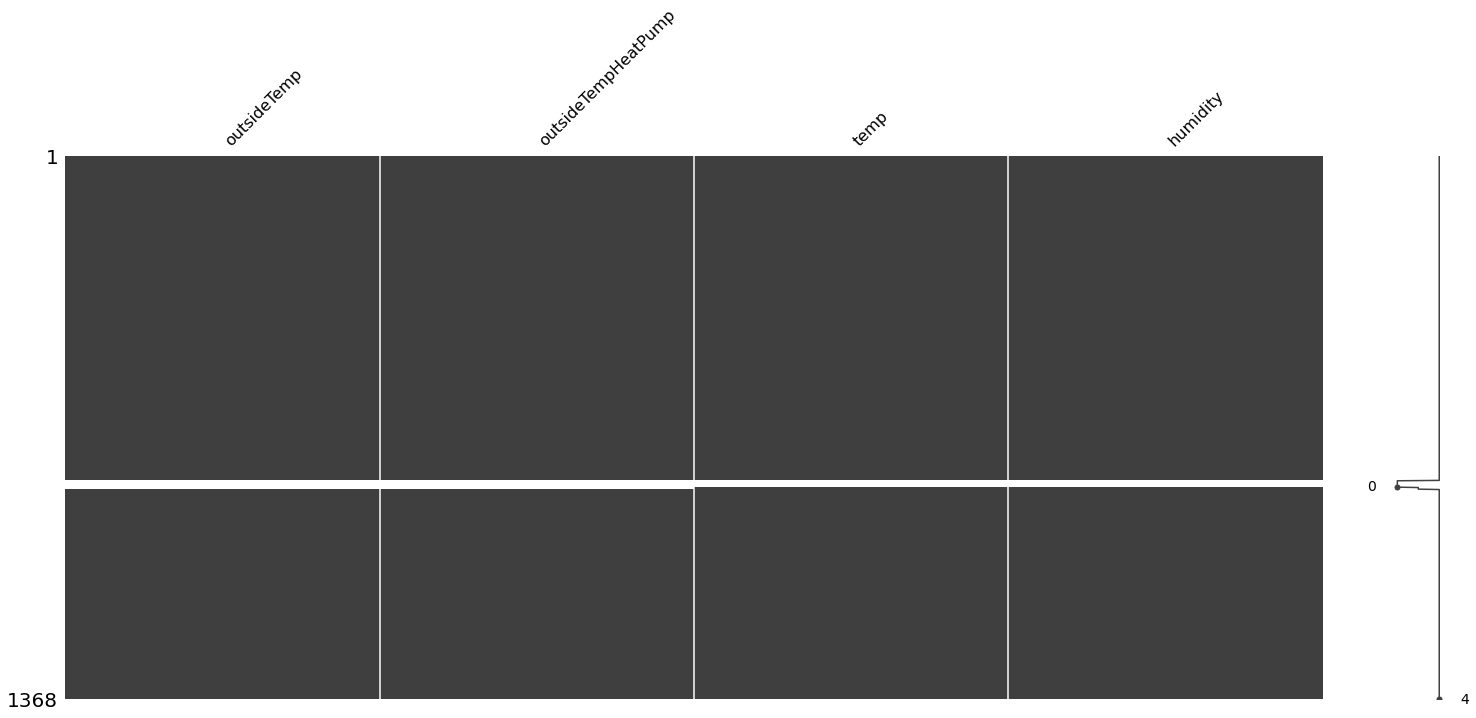

In [45]:
msno.matrix(markets[markets["marketId"]==93593].drop(["marketId", "date"], axis=1))

In [46]:
markets[markets["marketId"]==93593][markets["outsideTemp"].isnull()]["date"]

/tmp/ipykernel_2776330/4006068482.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  markets[markets["marketId"]==93593][markets["outsideTemp"].isnull()]["date"]


21337   2021-12-20 01:00:00+00:00
21338   2021-12-20 02:00:00+00:00
21339   2021-12-20 03:00:00+00:00
21340   2021-12-20 04:00:00+00:00
21341   2021-12-20 05:00:00+00:00
21342   2021-12-20 06:00:00+00:00
21343   2021-12-20 07:00:00+00:00
21344   2021-12-20 08:00:00+00:00
21345   2021-12-20 09:00:00+00:00
21346   2021-12-20 10:00:00+00:00
21347   2021-12-20 11:00:00+00:00
21348   2021-12-20 12:00:00+00:00
21349   2021-12-20 13:00:00+00:00
21350   2021-12-20 14:00:00+00:00
21351   2021-12-20 15:00:00+00:00
21352   2021-12-20 16:00:00+00:00
21353   2021-12-20 17:00:00+00:00
21354   2021-12-20 18:00:00+00:00
21355   2021-12-20 19:00:00+00:00
21356   2021-12-20 20:00:00+00:00
21357   2021-12-20 21:00:00+00:00
21358   2021-12-20 22:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]

In [47]:
fridges[fridges["marketId"]==93593]["sealChange"].unique()

array(['2021-12-14T00:00:00.000000000'], dtype='datetime64[ns]')

The day that there were no recordings was 6 days after the seal was changed in that supermarket, so it does not seem to be associated with the seal being changed. I would therefore say it is safe to drop the data. Imputation however could be possible if we needed to use an algorithm that related to the time data, where a missing day would be relevant. However, the graph demonstrates a steep change in temperature around the date of the missing data, (and no clear seasonal factor repeating between the days), therefore I believe that imputation would be inappropriate in this case.

/tmp/ipykernel_2776330/441337106.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.axvline(x=markets[markets["marketId"]==93593][markets["outsideTemp"].isnull()]["date"][21337], color="red")


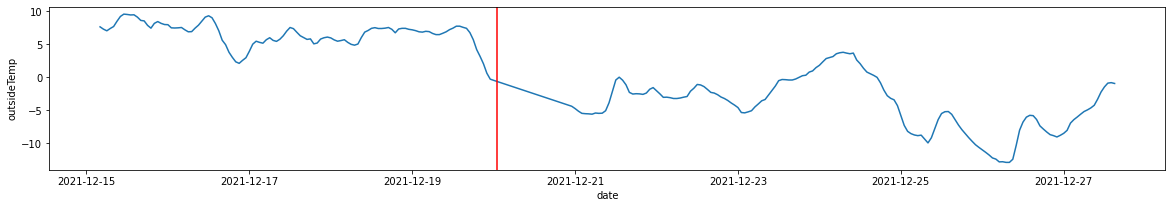

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(data = markets[markets["marketId"]==93593][["date", "outsideTemp"]].reset_index(inplace=False).iloc[700:1000], x="date", y="outsideTemp", ax=ax)
ax.axvline(x=markets[markets["marketId"]==93593][markets["outsideTemp"].isnull()]["date"][21337], color="red")

As in the majority of cases the missing data corresponds to an entire measurement variable being missing, the very few cases of small amount of data being missing can be manually inspected by hand, in order to investigate if imputation is appropriate, as in the case above.

### Identifying outliers<a name="outliers"></a>

Outliers are best identified using visualisations.

<AxesSubplot:>

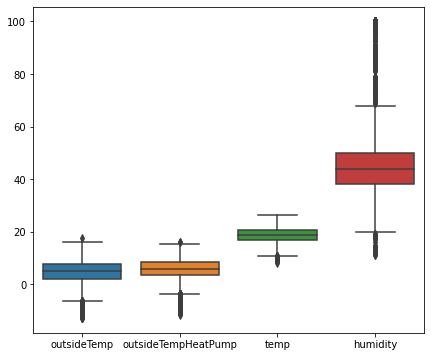

In [49]:
plt.figure(figsize=(7,6))
sns.boxplot(data=markets.drop(["marketId"], axis=1, inplace=False))

<AxesSubplot:>

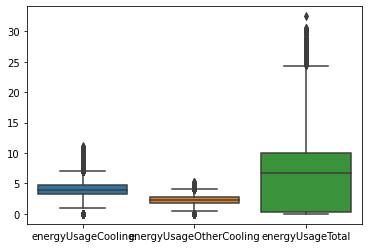

In [50]:
sns.boxplot(data=energy.drop(["marketId"], axis=1, inplace=False))

<AxesSubplot:>

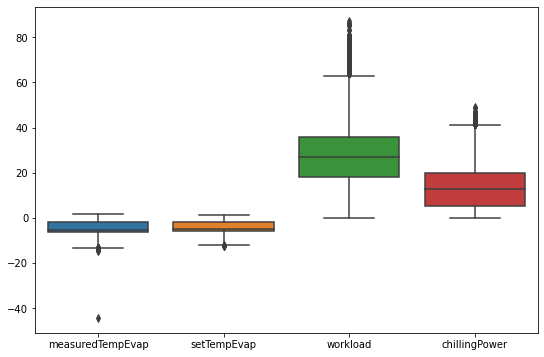

In [51]:
plt.figure(figsize=(9,6))
sns.boxplot(data=heatpumps.drop(["marketId"], axis=1, inplace=False))

<AxesSubplot:>

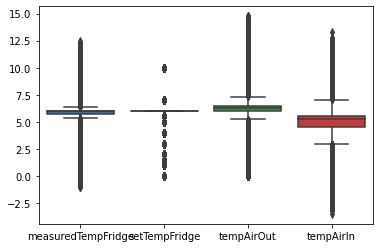

In [52]:
sns.boxplot(data=fridges[["measuredTempFridge", "setTempFridge", "tempAirOut", "tempAirIn"]])

<AxesSubplot:>

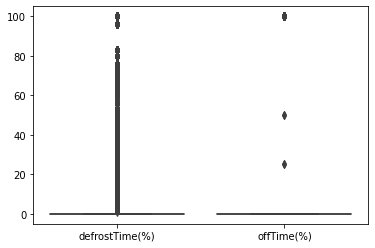

In [53]:
sns.boxplot(data=fridges[["defrostTime(%)", "offTime(%)"]])

In [54]:
fridges["offTime(%)"].value_counts(normalize=True)*100

0.000     99.986
100.000    0.012
50.000     0.001
25.000     0.001
Name: offTime(%), dtype: float64

Almost all of the values do not seem to be outliers: all of the values make practical sense (as the temperatures) or do not exceed expected bounds (such as the measurements given in percent).  
Although the boxplot marks many values as outliers on some of the figures, such as "outlet air temp" and "inlet air temp", this is moreso a result of the fact that the vast majority of the observations exist within an extremely small range of values. Unique situations that caused, for example, a high air pump utilisation to be required, may in fact of interest to the analysis, in determining what caused this unique event. The fridges with long "off times" could also be classified as "unusual events", as it is possible that the fridges were genuinely off for long periods of time, and thus the measurements are accurate. However, there is so little variation in this variable (99.9% of its values are 0), it is very unlikely that this feature would be used in a model anyway.

I believe that the only outliers that should be removed are the ones that reflect incorrect measurements, rather than unique situations. However, if these variables are used within a model, the extreme values should be again considered, as they may obscure any genuine relationships.

There is one obviously problematic outlier, an evaporation temperature measurement that is -40. This should be investigated.  
Furthermore, there are few values with "expected temperatures" that are not 6 degrees. This is possibly unwanted, due to the consistency within the rest of the dataset.

While the majority of the supermarkets have humidity values around 25-50, there is one supermarket with humidity values that are almost always around 100. Because this is so different to the rest of the dataset, it is unclear whether this supermarket is an exceptional case, or if it contains faulty measurements. Any analysis containing the humidity variables should create two models: one containing supermarket 88706 and one without, in order to ascertain the effect of these unusual readings on the analysis.

<AxesSubplot:xlabel='date', ylabel='humidity'>

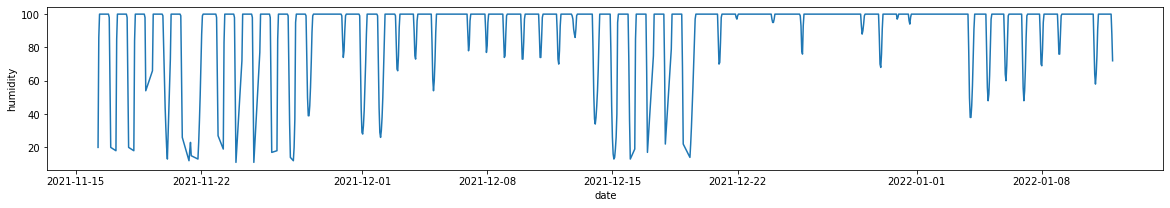

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(data = markets[markets["marketId"]==88706], x="date", y="humidity", ax=ax)

### Handling outliers

The outlier of the evaporation temperature measurement that is  < -40 needs to be investigated.  

In [56]:
heatpumps[heatpumps["measuredTempEvap"]<-40]

,marketId,hpId,date,measuredTempEvap,setTempEvap,workload,chillingPower,uniqueHpId
20297,85679,2.000,2022-01-02 15:00:00+00:00,-44.400,-10.000,6.000,4.250,85679.2.0


<AxesSubplot:xlabel='date', ylabel='measuredTempEvap'>

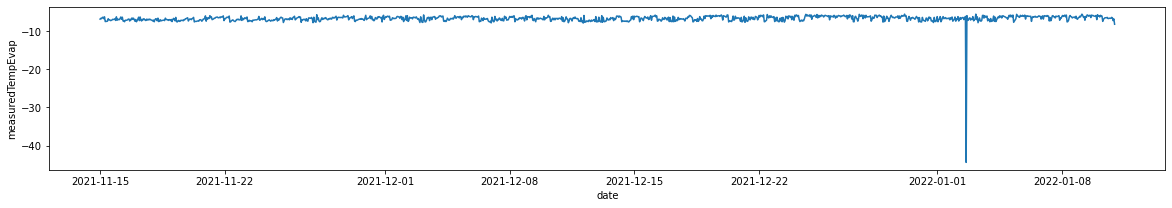

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(data = heatpumps[heatpumps["uniqueHpId"]=="85679.2.0"], x="date", y="measuredTempEvap", ax=ax)

Text(0.5, 1.0, 'Market 85679: Evaporator Temperatures')

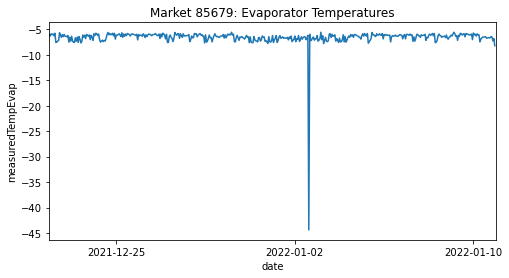

In [59]:
import datetime
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(data = heatpumps[heatpumps["uniqueHpId"]=="85679.2.0"], x="date", y="measuredTempEvap", ax=ax)
plt.xlim([datetime.date(2021, 12, 22), datetime.date(2022, 1, 11)])
plt.xticks(["2021-12-25", "2022-01-02", "2022-01-10"])
plt.title("Market 85679: Evaporator Temperatures")

In order to fix this outlier, the best course of action would simply be to impute, and replace the value with the preceeding one, due to the time stamped nature of the data. Due to the consistency in the trend of the rest of the data, this change to the dataset would likely not have an inadvertant effect.

In [60]:
heatpumps_impute = heatpumps.copy()
heatpumps_impute.iloc[20297, 3] = heatpumps.iloc[20296]["measuredTempEvap"]

In [61]:
heatpumps.iloc[20297, :]

marketId                                85679
hpId                                    2.000
date                2022-01-02 15:00:00+00:00
measuredTempEvap                      -44.400
setTempEvap                           -10.000
workload                                6.000
chillingPower                           4.250
uniqueHpId                          85679.2.0
Name: 20297, dtype: object

Text(0.5, 1.0, 'Market 85679: Fixed Evaporator Temperatures')

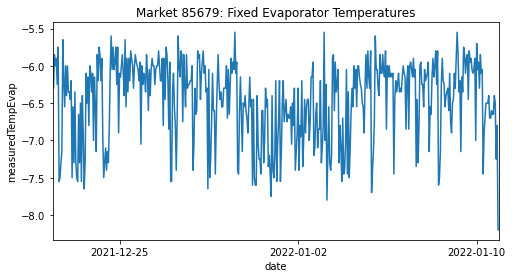

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(data = heatpumps_impute[heatpumps_impute["uniqueHpId"]=="85679.2.0"], x="date", y="measuredTempEvap", ax=ax)
plt.xlim([datetime.date(2021, 12, 22), datetime.date(2022, 1, 11)])
plt.xticks(["2021-12-25", "2022-01-02", "2022-01-10"])
plt.title("Market 85679: Fixed Evaporator Temperatures")

The data now looks much better.

There are few values with "expected temperatures" that are not 6 degrees. 82% of the dataset use 6 degrees as the expected, while 10% of the dataset use 1 degrees. As this is a significant portion, without further input from the business stakeholders to explain the expected temperatures, I would conclude that the 1 degree values may be intented targets, and I would not remove these values as outliers. I would therefore consider splitting my analysis into the data values using 6 degrees as the target, and 1 degrees (or other) as the target, due to the likelihood that these represent different fridge types.

In [63]:
fridges["setTempFridge"].value_counts(normalize=True)*100

6.000    82.939
1.000     9.257
4.000     4.081
2.000     1.484
3.000     0.371
5.000     0.371
5.500     0.371
10.000    0.371
1.500     0.371
7.000     0.371
0.000     0.013
Name: setTempFridge, dtype: float64

### Correlated features<a name="corr"></a>

Outside building temperature and outside pump temperature are very highly correlated, thus it likely that only one of these features would be necessary in a final model. None of the other features initially appear to be particuarly highly correlated. As there are only a very small number of features to begin with, I believe a PCA reduction on this dataset to be unnecessary. Correlated features would likely be removed from a model during a variable selection process anyway.

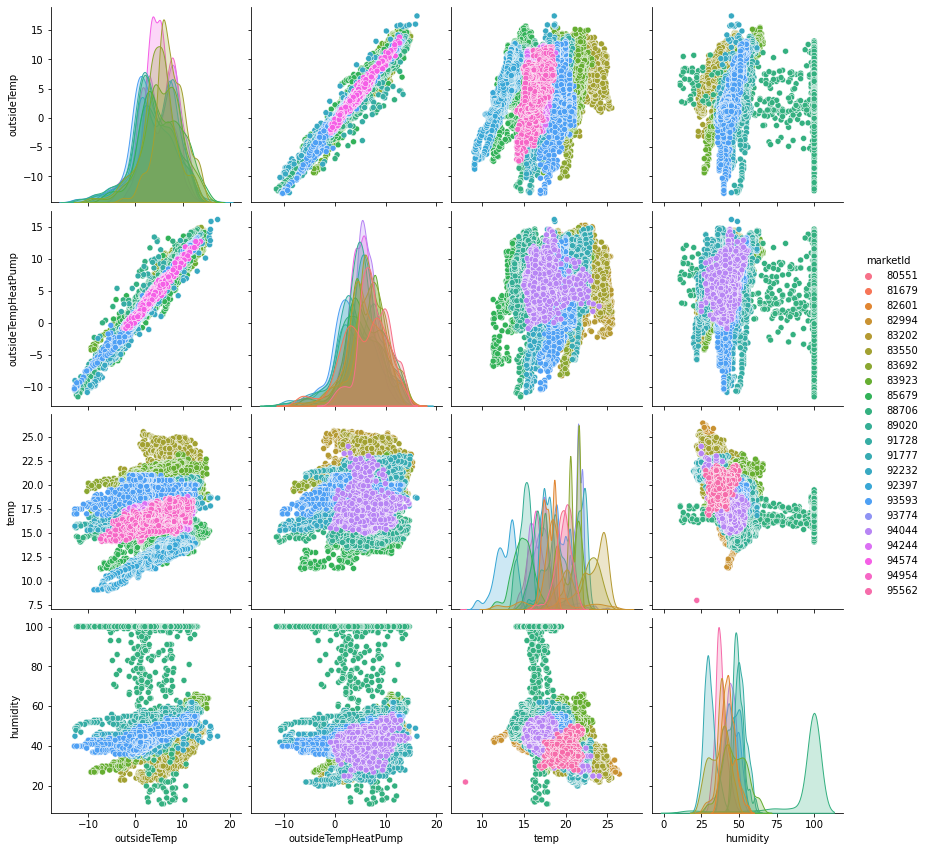

In [64]:
sns.pairplot(markets, hue="marketId", height=3)

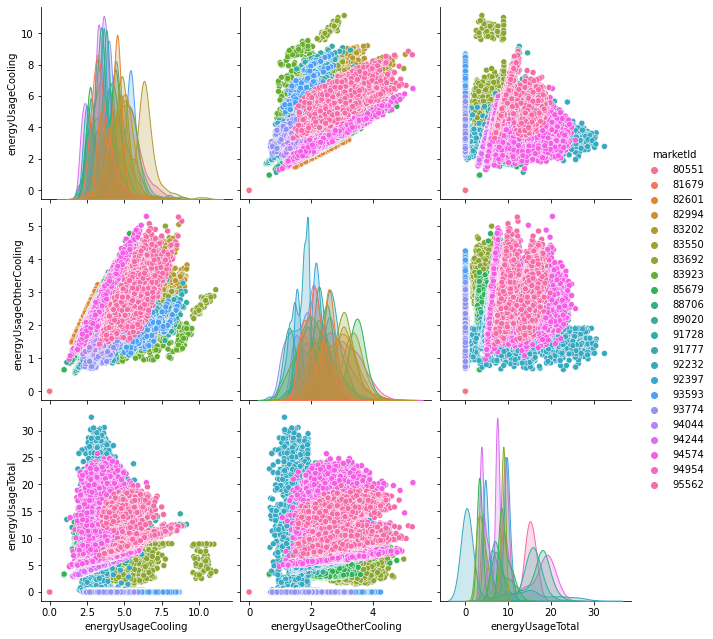

In [65]:
sns.pairplot(energy, hue="marketId", height=3)

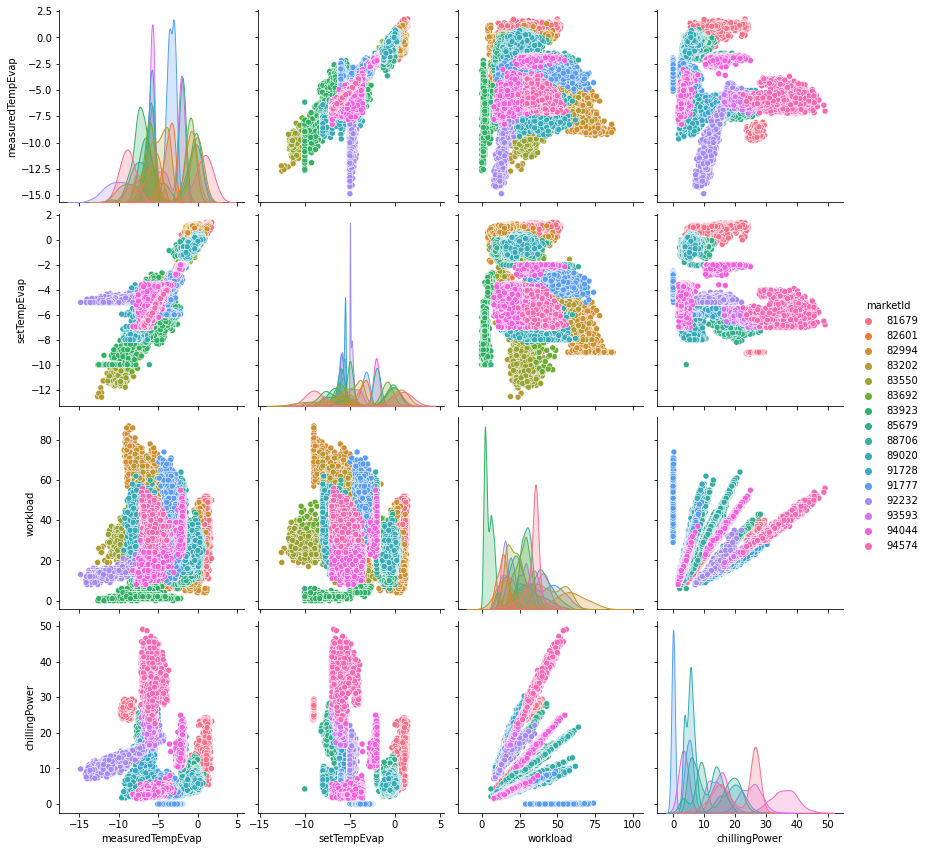

In [66]:
sns.pairplot(heatpumps_impute.drop(["hpId"], axis=1), hue="marketId", height=3)

The actual and inlet air temperatures appear correlated, with some odd clusters, which seem potentially related to certain markets/fridge groups. As a result, I would not consider dropping any features at this stage.

In [67]:
#sns.pairplot(fridge.drop(["hpId", "uniqueHpId", "setTempFridge", "fridgeId"], axis=1), hue="marketId", height=3)
Image(url = "https://i.imgur.com/2WXWeLA.png")

There are a very few specific fridge groups that have very high outlet air temperatures relative to their actual temperatures. This may reflect a relatively unusual environment surrounding these particular fridge groups.

In [68]:
# sns.pairplot(fridge.drop(["hpId", "marketId", "setTempFridge", "fridgeId"], axis=1), hue="uniqueHpId", height=3)
Image(url = "https://i.imgur.com/iHZofOU.png")

### Feature engineering<a name="feature"></a>

During the data import phase, I created a new id feature combining both the market and fridge group ids, as the same fridge group ids are used in every market. This new id allows every fridge group to be uniquely identified.

I create a feature showing the difference between the actual and expected fridge temperatures, as this may be useful in the analysis.

In [69]:
fridges["temp_diff"] = fridges["measuredTempFridge"] - fridges["setTempFridge"]
heatpumps["evaporate_temp_diff"] = heatpumps["measuredTempEvap"] - heatpumps["setTempEvap"]

We can also extract only the current day from the date column, in order to be able to compare it to the seal change date later.

In [70]:
fridges["only_day"] = fridges["date"].dt.date
heatpumps["only_day"] = heatpumps["date"].dt.date
energy["only_day"] = energy["date"].dt.date
markets["only_day"] = markets["date"].dt.date

In [71]:
fridges.head()

,marketId,fridgeId,hpId,date,measuredTempFridge,setTempFridge,tempAirOut,tempAirIn,defrostTime(%),offTime(%),sealChange,uniqueHpId,temp_diff,only_day
0,85679,1171,1.000,2021-11-15 00:00:00+00:00,6.500,6.000,6.500,6.500,50.000,0.000,2021-12-13,85679.1.0,0.500,2021-11-15
1,85679,1171,1.000,2021-11-15 01:00:00+00:00,7.000,6.000,7.500,7.000,50.000,0.000,2021-12-13,85679.1.0,1.000,2021-11-15
2,85679,1171,1.000,2021-11-15 02:00:00+00:00,5.750,6.000,6.000,5.500,0.000,0.000,2021-12-13,85679.1.0,-0.250,2021-11-15
3,85679,1171,1.000,2021-11-15 03:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,2021-12-13,85679.1.0,0.000,2021-11-15
4,85679,1171,1.000,2021-11-15 04:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,2021-12-13,85679.1.0,0.000,2021-11-15


Each market had all of its seals changed on one day. Therefore this information can be added to the other datasets.

In [72]:
for market in fridges["marketId"].unique():
    print("Change day(s) for market", market, "=", fridges[fridges["marketId"]==market]["sealChange"].unique())

Change day(s) for market 85679 = ['2021-12-13T00:00:00.000000000']
Change day(s) for market 83923 = ['2021-12-10T00:00:00.000000000']
Change day(s) for market 83692 = ['2022-01-19T00:00:00.000000000']
Change day(s) for market 83550 = ['2021-12-17T00:00:00.000000000']
Change day(s) for market 83202 = ['2021-12-15T00:00:00.000000000']
Change day(s) for market 82994 = ['2021-12-13T00:00:00.000000000']
Change day(s) for market 82601 = ['2022-01-25T00:00:00.000000000']
Change day(s) for market 81679 = ['2021-12-08T00:00:00.000000000']
Change day(s) for market 89020 = ['2022-01-26T00:00:00.000000000']
Change day(s) for market 88706 = ['2021-12-14T00:00:00.000000000']
Change day(s) for market 91777 = ['2022-01-20T00:00:00.000000000']
Change day(s) for market 91728 = ['2021-12-14T00:00:00.000000000']
Change day(s) for market 92232 = ['2021-12-02T00:00:00.000000000']
Change day(s) for market 93593 = ['2021-12-14T00:00:00.000000000']
Change day(s) for market 94044 = ['2022-01-31T00:00:00.0000000

In [73]:
market_change_days = pd.DataFrame(fridges.groupby("marketId")["sealChange"].unique()).reset_index()
market_change_days["sealChange"] = market_change_days["sealChange"].apply(lambda row: row[0])
market_change_days["sealChange"] = market_change_days["sealChange"].dt.date

In [74]:
market_change_days_dict = market_change_days.set_index("marketId").T.to_dict("records")[0]

In [75]:
heatpumps["sealChange"] = heatpumps["marketId"].map(market_change_days_dict)
energy["sealChange"] = energy["marketId"].map(market_change_days_dict)
markets["sealChange"] = markets["marketId"].map(market_change_days_dict)

In [76]:
markets.tail()

,marketId,date,outsideTemp,outsideTempHeatPump,temp,humidity,only_day,sealChange
30091,95562,2022-02-24 19:00:00+00:00,NaN,NaN,20.000,38.000,2022-02-24,2022-01-27
30092,95562,2022-02-24 20:00:00+00:00,NaN,NaN,19.875,36.000,2022-02-24,2022-01-27
30093,95562,2022-02-24 21:00:00+00:00,NaN,NaN,20.625,37.000,2022-02-24,2022-01-27
30094,95562,2022-02-24 22:00:00+00:00,NaN,NaN,20.250,36.000,2022-02-24,2022-01-27
30095,95562,2022-02-24 23:00:00+00:00,NaN,NaN,19.625,37.000,2022-02-24,2022-01-27


We can create a new feature, which describes whether or not an observation was recorded before or after the door seal was changed.  

In [77]:
def compare_dates(row):
    if pd.isna(row["sealChange"]) or pd.isna(row["only_day"]):
        return np.nan
    elif row["only_day"] < row["sealChange"]:
        return "before"
    elif row["only_day"] > row["sealChange"]:
        return "after"
    else:
        return "on"

In [78]:
fridges["before_after_on"] = fridges.apply(compare_dates, axis=1)
heatpumps["before_after_on"] = heatpumps.apply(compare_dates, axis=1)
energy["before_after_on"] = energy.apply(compare_dates, axis=1)
markets["before_after_on"] = markets.apply(compare_dates, axis=1)

/tmp/ipykernel_2776330/3351608168.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif row["only_day"] < row["sealChange"]:
/tmp/ipykernel_2776330/3351608168.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif row["only_day"] > row["sealChange"]:


In [79]:
fridges

,marketId,fridgeId,hpId,date,measuredTempFridge,setTempFridge,tempAirOut,tempAirIn,defrostTime(%),offTime(%),sealChange,uniqueHpId,temp_diff,only_day,before_after_on
0,85679,1171,1.000,2021-11-15 00:00:00+00:00,6.500,6.000,6.500,6.500,50.000,0.000,2021-12-13,85679.1.0,0.500,2021-11-15,before
1,85679,1171,1.000,2021-11-15 01:00:00+00:00,7.000,6.000,7.500,7.000,50.000,0.000,2021-12-13,85679.1.0,1.000,2021-11-15,before
2,85679,1171,1.000,2021-11-15 02:00:00+00:00,5.750,6.000,6.000,5.500,0.000,0.000,2021-12-13,85679.1.0,-0.250,2021-11-15,before
3,85679,1171,1.000,2021-11-15 03:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,2021-12-13,85679.1.0,0.000,2021-11-15,before
4,85679,1171,1.000,2021-11-15 04:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,2021-12-13,85679.1.0,0.000,2021-11-15,before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368744,92397,471309,NaN,2022-01-03 19:00:00+00:00,1.000,1.000,2.000,0.000,0.000,0.000,2021-12-06,92397.nan,0.000,2022-01-03,after
368745,92397,471309,NaN,2022-01-03 20:00:00+00:00,0.750,1.000,2.000,0.000,0.000,0.000,2021-12-06,92397.nan,-0.250,2022-01-03,after
368746,92397,471309,NaN,2022-01-03 21:00:00+00:00,1.000,1.000,2.000,0.000,0.000,0.000,2021-12-06,92397.nan,0.000,2022-01-03,after
368747,92397,471309,NaN,2022-01-03 22:00:00+00:00,1.000,1.000,2.000,0.000,0.000,0.000,2021-12-06,92397.nan,0.000,2022-01-03,after


When looking at the day "on" which the seal was changed, there is a large spike in the air temperatures, suggesting that this was the time at which the seal was changed. However we cannot know this for certain,

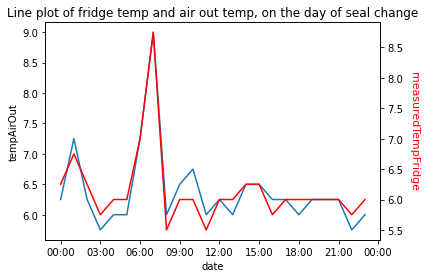

In [80]:
import matplotlib.dates as mdates
ax = sns.lineplot(data=fridges[(fridges["before_after_on"]=="on") & (fridges["fridgeId"]==1171)], x="date", y="tempAirOut")
ax.set_title("Line plot of fridge temp and air out temp, on the day of seal change")
ax1 = ax.twinx()
sns.lineplot(data=fridges[(fridges["before_after_on"]=="on") & (fridges["fridgeId"]==1171)], x="date", y="measuredTempFridge", color="red", ax=ax1)
ax1.set_ylabel("measuredTempFridge", color="red", rotation=270, labelpad=16, fontsize=11);
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))

In [81]:
fridges[fridges["before_after_on"]=="on"].groupby("fridgeId")["measuredTempFridge"].describe()

,count,mean,std,min,25%,50%,75%,max
fridgeId,,,,,,,,
1171,24.000,6.156,0.642,5.500,6.000,6.000,6.250,8.750
1175,24.000,6.323,0.665,5.750,6.000,6.000,6.500,8.750
1177,24.000,6.125,0.532,5.500,5.750,6.000,6.062,7.750
1180,24.000,1.167,0.896,0.000,0.938,1.000,1.000,4.000
1185,24.000,1.219,0.971,0.500,0.688,1.000,1.250,4.250
...,...,...,...,...,...,...,...,...
471299,24.000,6.083,0.343,5.750,6.000,6.000,6.000,7.250
471302,24.000,6.021,0.194,5.750,6.000,6.000,6.000,6.500
471304,24.000,6.052,0.255,5.750,6.000,6.000,6.000,6.750


### Aggregating the data<a name="agg"></a>

We can aggregate some of the datasets, in order to make it viable to combine them with other datasets.  

The energy dataset uses 15 minute intervals, whereas the other datasets use 1 hour intervals, hence it can be aggregated to 1 hour.  

In [82]:
agg_energy = energy.groupby("marketId").resample("H", on="date").agg({"marketId":lambda row: pd.Series.mode(row, dropna=False)[0], 
                                                                       "energyUsageCooling":"sum", "energyUsageOtherCooling":"sum", "energyUsageTotal":"sum" , 
                                                                       "only_day":lambda row: pd.Series.mode(row, dropna=False)[0],
                                                                       "sealChange":lambda row: pd.Series.mode(row, dropna=False)[0],
                                                                       "before_after_on":lambda row: pd.Series.mode(row, dropna=False)[0]})
agg_energy.index = agg_energy.index.droplevel()
agg_energy = agg_energy.reset_index()

In [83]:
agg_energy

,date,marketId,energyUsageCooling,energyUsageOtherCooling,energyUsageTotal,only_day,sealChange,before_after_on
0,2021-11-15 00:00:00+00:00,80551,0.000,0.000,0.000,2021-11-15,NaN,NaN
1,2021-11-15 01:00:00+00:00,80551,0.000,0.000,0.000,2021-11-15,NaN,NaN
2,2021-11-15 02:00:00+00:00,80551,0.000,0.000,0.000,2021-11-15,NaN,NaN
3,2021-11-15 03:00:00+00:00,80551,0.000,0.000,0.000,2021-11-15,NaN,NaN
4,2021-11-15 04:00:00+00:00,80551,0.000,0.000,0.000,2021-11-15,NaN,NaN
...,...,...,...,...,...,...,...,...
30091,2022-02-24 19:00:00+00:00,95562,19.950,10.400,62.125,2022-02-24,2022-01-27,after
30092,2022-02-24 20:00:00+00:00,95562,19.375,12.175,63.350,2022-02-24,2022-01-27,after
30093,2022-02-24 21:00:00+00:00,95562,19.775,12.600,56.925,2022-02-24,2022-01-27,after
30094,2022-02-24 22:00:00+00:00,95562,24.450,12.250,44.625,2022-02-24,2022-01-27,after


Some of the variables only exist at one level, e.g. chiller power only exists at the fridge groups level. We can use the combined hpIds to reproduce that data down back into the fridge dataset, by merging the data together into one large extended "fridge" dataset. This dataset does not use a relational form, therefore there will be a lot of repetition of data, for example, across all of the fridges in the same supermarket.

In [84]:
fridge_extended = fridges.copy()

In [85]:
fridge_extended = pd.merge(fridge_extended, heatpumps[["uniqueHpId", "date", "measuredTempEvap", "setTempEvap", "workload", "chillingPower", "evaporate_temp_diff"]],
                                       on=["uniqueHpId", "date"], how="left")

In [86]:
fridge_extended = pd.merge(fridge_extended, agg_energy[["date", "marketId", "energyUsageCooling", "energyUsageOtherCooling", "energyUsageTotal"]],
                                     on=["marketId", "date"], how="left")

In [87]:
fridge_extended = pd.merge(fridge_extended, markets[["marketId", "date", "outsideTemp", "outsideTempHeatPump", "temp", "humidity"]],
                           on=["marketId", "date"], how="left")

In [88]:
fridge_extended

,marketId,fridgeId,hpId,date,measuredTempFridge,setTempFridge,tempAirOut,tempAirIn,defrostTime(%),offTime(%),...,workload,chillingPower,evaporate_temp_diff,energyUsageCooling,energyUsageOtherCooling,energyUsageTotal,outsideTemp,outsideTempHeatPump,temp,humidity
0,85679,1171,1.000,2021-11-15 00:00:00+00:00,6.500,6.000,6.500,6.500,50.000,0.000,...,26.000,8.000,0.000,11.075,9.750,13.525,8.425,9.900,15.225,NaN
1,85679,1171,1.000,2021-11-15 01:00:00+00:00,7.000,6.000,7.500,7.000,50.000,0.000,...,26.000,8.000,-0.000,11.625,10.300,13.575,8.225,9.900,15.025,NaN
2,85679,1171,1.000,2021-11-15 02:00:00+00:00,5.750,6.000,6.000,5.500,0.000,0.000,...,26.000,8.125,-0.000,11.325,10.025,13.275,8.050,9.650,15.250,NaN
3,85679,1171,1.000,2021-11-15 03:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,...,27.000,8.250,0.000,11.800,10.525,13.025,7.825,9.350,15.525,NaN
4,85679,1171,1.000,2021-11-15 04:00:00+00:00,6.000,6.000,6.000,6.000,0.000,0.000,...,26.000,8.125,0.050,12.375,11.125,12.900,7.675,8.950,15.275,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368744,92397,471309,NaN,2022-01-03 19:00:00+00:00,1.000,1.000,2.000,0.000,0.000,0.000,...,NaN,NaN,NaN,15.850,9.150,36.925,6.700,NaN,13.500,NaN
368745,92397,471309,NaN,2022-01-03 20:00:00+00:00,0.750,1.000,2.000,0.000,0.000,0.000,...,NaN,NaN,NaN,14.900,8.900,36.575,6.900,NaN,13.500,NaN
368746,92397,471309,NaN,2022-01-03 21:00:00+00:00,1.000,1.000,2.000,0.000,0.000,0.000,...,NaN,NaN,NaN,15.375,8.650,37.225,7.050,NaN,13.500,NaN
368747,92397,471309,NaN,2022-01-03 22:00:00+00:00,1.000,1.000,2.000,0.000,0.000,0.000,...,NaN,NaN,NaN,12.550,8.025,27.050,7.300,NaN,13.575,NaN


In [89]:
fridge_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368749 entries, 0 to 368748
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   marketId                 368749 non-null  object             
 1   fridgeId                 368749 non-null  category           
 2   hpId                     285473 non-null  category           
 3   date                     368749 non-null  datetime64[ns, UTC]
 4   measuredTempFridge       368720 non-null  float64            
 5   setTempFridge            368720 non-null  float64            
 6   tempAirOut               368720 non-null  float64            
 7   tempAirIn                368720 non-null  float64            
 8   defrostTime(%)           368748 non-null  float64            
 9   offTime(%)               368748 non-null  float64            
 10  sealChange               368749 non-null  datetime64[ns]     
 11  uniqueHpId   

In [90]:
fridge_extended.describe()

,measuredTempFridge,setTempFridge,tempAirOut,tempAirIn,defrostTime(%),offTime(%),temp_diff,measuredTempEvap,setTempEvap,workload,chillingPower,evaporate_temp_diff,energyUsageCooling,energyUsageOtherCooling,energyUsageTotal,outsideTemp,outsideTempHeatPump,temp,humidity
count,368720.000,368720.000,368720.000,368720.000,368748.000,368748.000,368720.000,285177.000,285177.000,285177.000,178557.000,285177.000,368749.000,368749.000,368749.000,220802.000,250933.000,325038.000,200610.000
mean,5.430,5.381,5.948,4.631,4.525,0.013,0.049,-3.724,-3.274,27.462,16.624,-0.450,15.754,8.688,18.400,4.847,5.598,18.458,46.607
std,1.609,1.585,1.624,1.812,16.169,1.124,0.531,2.973,2.616,13.460,11.159,1.270,5.307,3.607,23.999,4.141,3.786,2.978,16.048
min,-1.000,0.000,0.000,-3.500,0.000,0.000,-4.000,-44.400,-12.600,0.000,0.000,-34.400,0.000,0.000,0.000,-12.875,-11.600,8.000,11.000
25%,5.750,6.000,6.000,4.500,0.000,0.000,0.000,-6.000,-5.550,17.000,8.250,-0.350,13.125,7.050,0.000,2.200,3.350,16.400,38.000
50%,6.000,6.000,6.250,5.250,0.000,0.000,0.000,-3.550,-3.600,26.000,15.000,-0.050,15.725,9.100,0.000,5.000,5.600,18.475,44.000
75%,6.000,6.000,6.500,5.500,0.000,0.000,0.000,-0.975,-0.650,37.000,23.500,0.100,19.000,11.040,34.025,7.750,8.100,20.750,50.000
max,12.500,10.000,14.750,13.250,100.000,100.000,7.500,1.750,1.400,87.000,49.125,4.150,33.175,17.300,114.500,17.425,16.200,26.450,100.000
